In [ ]:
import torch
import time
import snntorch as snn

lif = snn.Leaky(beta=0.9)
lif = lif.to('cuda')

num_steps = 20000

x = torch.rand(num_steps)
mem = torch.zeros(1)
spk = torch.zeros(1)

start_time = time.time()
for step in range(num_steps):
  spk, mem = lif(x[step], mem=mem)

end_time = time.time()

print(f"{end_time-start_time}")

In [ ]:
lif = snn.LinearLeaky(beta=0.9)
lif = lif.to('cuda')

# lif = torch.compile(lif, mode="reduce-overhead", fullgraph=True, dynamic=False)

timesteps = 100000
batch = 1
channels = 1
print("timesteps: ", timesteps)
print("batch: ", batch)
print("channels: ", channels)
print()

input_ = torch.arange(1, timesteps * batch * channels + 1).float().view(timesteps, batch, channels).to('cuda')
start_time = time.time()
lif.forward(input_)
end_time = time.time()

print(f"{end_time-start_time}")

torch.Size([10, 20, 20])
torch.Size([10, 20])
torch.Size([])
------------decay filter------------
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000],
        [0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048,
         0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048,
         0.9048, 0.9048],
        [0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187,
         0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187,
         0.8187, 0.8187],
        [0.7408, 0.7408, 0.7408, 0.7408, 0.7408, 0.7408, 0.7408, 0.7408, 0.7408,
         0.7408, 0.7408, 0.7408, 0.7408, 0.7408, 0.7408, 0.7408, 0.7408, 0.7408,
         0.7408, 0.7408],
        [0.6703, 0.6703, 0.6703, 0.6703, 0.6703, 0.6703, 0.6703, 0.6703, 0.6703,
         0.6703, 0.6703, 0.6703, 0.6703, 0.6703, 0.6703, 0.6703, 0.67

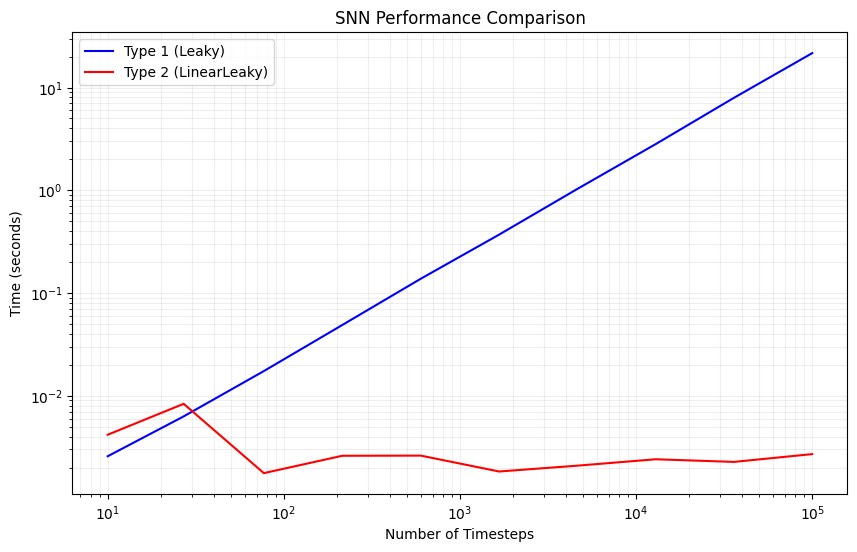

In [7]:
import torch
import time
import snntorch as snn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from snntorch._neurons.stateleaky import StateLeaky

BATCH_SIZE = 20
CHANNELS = 20

device = "cuda"

def bench_type1(num_steps):
    lif = snn.Leaky(beta=0.9).to(device)
    x = torch.rand(num_steps).to(device)
    mem = torch.zeros(BATCH_SIZE, CHANNELS).to(device)
    spk = torch.zeros(BATCH_SIZE, CHANNELS).to(device)
    
    start_time = time.time()
    for step in range(num_steps):
        spk, mem = lif(x[step], mem=mem)
    end_time = time.time()
    
    return end_time - start_time

def bench_type2(timesteps):
    lif = StateLeaky(beta=0.9).to(device)
    input_ = torch.arange(1, timesteps * BATCH_SIZE * CHANNELS + 1).float().view(timesteps, BATCH_SIZE, CHANNELS).to(device)
    
    start_time = time.time()
    lif.forward(input_)
    end_time = time.time()
    
    return end_time - start_time

# Define timesteps on log scale
timesteps = np.logspace(1, 5, num=10, dtype=int)

# Run benchmarks
times1 = []
times2 = []
for steps in timesteps:
    # Run each benchmark multiple times and take average for more stable results
    n_runs = 2
    time1 = np.mean([bench_type1(steps) for _ in range(n_runs)])
    time2 = np.mean([bench_type2(steps) for _ in range(n_runs)])
    times1.append(time1)
    times2.append(time2)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(timesteps, times1, 'b-', label='Type 1 (Leaky)')
plt.plot(timesteps, times2, 'r-', label='Type 2 (LinearLeaky)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Number of Timesteps')
plt.ylabel('Time (seconds)')
plt.title('SNN Performance Comparison')
plt.legend()
plt.savefig("snn_performance_comparison.svg", format="svg")

# Print the results
print("Benchmark Results:")
print("\nTimesteps  |  Leaky (s)  |  Linear Leaky (s)  |  Ratio (T2/T1)")
print("-" * 55)
for i, steps in enumerate(timesteps):
    ratio = times2[i] / times1[i]
    print(f"{steps:9d} | {times1[i]:10.4f} | {times2[i]:10.4f} | {ratio:10.2f}")

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
from snntorch._neurons.stateleaky import StateLeaky
from tqdm import tqdm
import torch.nn.functional as F
import wandb

with open("output.txt", "w") as f:
    f.write("\n")

def initialize_wandb():
    wandb.init(project="snntorch-ssm", config={
    })

# Hyperparameters
SEQ_LENGTH = 128
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

# Load TinyStories dataset from Hugging Face
dataset = load_dataset("roneneldan/TinyStories", split="train")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Use GPT-2 tokenizer for simplicity
tokenizer.pad_token = tokenizer.eos_token  # Use the end-of-sequence token as padding

print("initialized tokenizer")

VOCAB_SIZE = tokenizer.vocab_size

def tokenize_fn(example):
    tokens = tokenizer(example["text"], truncation=True, max_length=SEQ_LENGTH, padding="max_length")
    return {"input_ids": tokens["input_ids"]}

tokenized_dataset = dataset.map(tokenize_fn, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids"])

print("tokenized dataset")

# DataLoader
dataloader = DataLoader(tokenized_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model Definition
class SNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SNNLanguageModel, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.lif1 = StateLeaky(beta=0.9, learn_beta=True)  # Optimized processing for full timesteps
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.lif2 = StateLeaky(beta=0.9, learn_beta=True)  # Optimized processing for full timesteps
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.lif3 = StateLeaky(beta=0.9, learn_beta=True)  # Optimized processing for full timesteps
        self.fc4 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = x.reshape(-1, x.shape[-1])
        hidden = self.fc1(x)  # Linear transformation to hidden_dim
        hidden = hidden.reshape(SEQ_LENGTH-1, -1, hidden.shape[-1])
        hidden, _ = self.lif1(hidden)  # StateLeaky handles all timesteps internally
        hidden = hidden.reshape(-1, hidden.shape[-1])
        hidden = self.fc2(hidden)  # Final transformation to vocabulary size
        hidden = torch.relu(hidden)
        hidden = hidden.reshape(SEQ_LENGTH-1, -1, hidden.shape[-1])
        hidden, _ = self.lif2(hidden)  # StateLeaky handles all timesteps internally
        hidden = hidden.reshape(-1, hidden.shape[-1])
        hidden = self.fc3(hidden)  # Final transformation to vocabulary size
        hidden = torch.relu(hidden)
        hidden = hidden.reshape(SEQ_LENGTH-1, -1, hidden.shape[-1])
        hidden, _ = self.lif3(hidden)  # StateLeaky handles all timesteps internally
        hidden = hidden.reshape(-1, hidden.shape[-1])
        output = self.fc4(hidden)  # Final transformation to vocabulary size
        output = output.reshape(SEQ_LENGTH-1, -1, output.shape[-1])
        return output

initialize_wandb()

# Initialize model, loss, and optimizer
model = SNNLanguageModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    batch_num = 0
    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch+1}"):
        batch_num += 1
        # print("batch num: ", batch_num)
        x = batch["input_ids"].to(DEVICE)

        # process batch: one hot / teacher forcing setup / permute to (seq_length, batch, vocab_size)
        x = F.one_hot(x, num_classes=VOCAB_SIZE).float()
        y = x[:, 1:]  # Target: next token in the sequence
        x = x[:, :-1]  # Input: all but the last token
        x = x.permute(1, 0, 2)
        y = y.permute(1, 0, 2)

        optimizer.zero_grad()

        output = model(x)

        # print the decoding
        if batch_num % 50 == 0:
            output = output.permute(1, 0, 2)
            seq_translate = torch.argmax(output[0], dim=-1)
            assert seq_translate.shape[0] == SEQ_LENGTH-1
            with open("output.txt", "a") as f:
                f.write(tokenizer.decode(seq_translate))
                f.write("\n")
            output = output.permute(1, 0, 2)

        assert output.shape == (SEQ_LENGTH-1, BATCH_SIZE, VOCAB_SIZE) 
        assert y.shape == (SEQ_LENGTH-1, BATCH_SIZE, VOCAB_SIZE)

        y = y.argmax(dim=-1)
        loss = criterion(output.reshape(-1, VOCAB_SIZE), y.reshape(-1))  # Compute loss
        wandb.log({"loss": loss.item()})

        loss.backward()
        optimizer.step()

        if batch_num % 50 == 0:
            print(loss.item())

        train_loss += loss.item()

    train_loss /= len(dataloader)
    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")

print("Training Complete!")


Device:  cuda
initialized tokenizer
tokenized dataset


loss,██▇▇▆▅▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▂▃▃▁▁▂▂▂▂▁▂▁▂
loss,5.21881


Training Epoch 1:   0%|          | 54/66242 [00:01<35:02, 31.49it/s]

8.532508850097656


Training Epoch 1:   0%|          | 106/66242 [00:03<35:06, 31.39it/s]

6.283369541168213


Training Epoch 1:   0%|          | 154/66242 [00:04<35:04, 31.41it/s]

6.097978115081787


Training Epoch 1:   0%|          | 206/66242 [00:06<35:01, 31.42it/s]

5.940324783325195


Training Epoch 1:   0%|          | 254/66242 [00:08<35:01, 31.40it/s]

6.038052558898926


Training Epoch 1:   0%|          | 306/66242 [00:09<34:58, 31.42it/s]

5.888880729675293


Training Epoch 1:   1%|          | 354/66242 [00:11<35:01, 31.35it/s]

5.702764987945557


Training Epoch 1:   1%|          | 406/66242 [00:12<34:54, 31.43it/s]

5.8296332359313965


Training Epoch 1:   1%|          | 454/66242 [00:14<34:55, 31.39it/s]

5.75023078918457


Training Epoch 1:   1%|          | 506/66242 [00:16<35:00, 31.30it/s]

5.656304836273193


Training Epoch 1:   1%|          | 554/66242 [00:17<34:52, 31.40it/s]

5.814284801483154


Training Epoch 1:   1%|          | 606/66242 [00:19<34:54, 31.34it/s]

5.7206711769104


Training Epoch 1:   1%|          | 654/66242 [00:20<34:48, 31.41it/s]

5.63857364654541


Training Epoch 1:   1%|          | 706/66242 [00:22<34:42, 31.47it/s]

5.619405746459961


Training Epoch 1:   1%|          | 754/66242 [00:24<34:43, 31.43it/s]

5.663363933563232


Training Epoch 1:   1%|          | 806/66242 [00:25<34:36, 31.52it/s]

5.5460405349731445


Training Epoch 1:   1%|▏         | 854/66242 [00:27<34:43, 31.38it/s]

5.421546459197998


Training Epoch 1:   1%|▏         | 906/66242 [00:28<34:33, 31.50it/s]

5.474724292755127


Training Epoch 1:   1%|▏         | 954/66242 [00:30<34:28, 31.56it/s]

5.541903018951416


Training Epoch 1:   2%|▏         | 1006/66242 [00:32<34:36, 31.41it/s]

5.342320919036865


Training Epoch 1:   2%|▏         | 1054/66242 [00:33<34:37, 31.38it/s]

5.375638008117676


Training Epoch 1:   2%|▏         | 1106/66242 [00:35<34:35, 31.39it/s]

5.39929723739624


Training Epoch 1:   2%|▏         | 1154/66242 [00:36<34:41, 31.26it/s]

5.440244197845459


Training Epoch 1:   2%|▏         | 1206/66242 [00:38<34:32, 31.39it/s]

5.342031478881836


Training Epoch 1:   2%|▏         | 1254/66242 [00:39<34:27, 31.44it/s]

5.4839091300964355


Training Epoch 1:   2%|▏         | 1306/66242 [00:41<34:36, 31.27it/s]

5.477057933807373


Training Epoch 1:   2%|▏         | 1354/66242 [00:43<34:28, 31.37it/s]

5.444192886352539


Training Epoch 1:   2%|▏         | 1406/66242 [00:44<34:33, 31.27it/s]

5.338193893432617


Training Epoch 1:   2%|▏         | 1454/66242 [00:46<34:21, 31.43it/s]

5.365905284881592


Training Epoch 1:   2%|▏         | 1506/66242 [00:47<34:18, 31.45it/s]

5.441812038421631


Training Epoch 1:   2%|▏         | 1554/66242 [00:49<34:13, 31.50it/s]

5.398020267486572


Training Epoch 1:   2%|▏         | 1606/66242 [00:51<34:15, 31.45it/s]

5.382111549377441


Training Epoch 1:   2%|▏         | 1654/66242 [00:52<34:17, 31.39it/s]

5.351563930511475


Training Epoch 1:   3%|▎         | 1706/66242 [00:54<34:18, 31.35it/s]

5.387162685394287


Training Epoch 1:   3%|▎         | 1754/66242 [00:55<34:03, 31.56it/s]

5.400020599365234


Training Epoch 1:   3%|▎         | 1806/66242 [00:57<34:07, 31.47it/s]

5.230320453643799


Training Epoch 1:   3%|▎         | 1854/66242 [00:59<34:00, 31.55it/s]

5.243389129638672


Training Epoch 1:   3%|▎         | 1906/66242 [01:00<34:21, 31.21it/s]

5.358674049377441


Training Epoch 1:   3%|▎         | 1954/66242 [01:02<34:10, 31.35it/s]

5.326239109039307


Training Epoch 1:   3%|▎         | 2006/66242 [01:03<33:59, 31.50it/s]

5.2092814445495605


Training Epoch 1:   3%|▎         | 2054/66242 [01:05<33:56, 31.52it/s]

5.1731791496276855


Training Epoch 1:   3%|▎         | 2106/66242 [01:07<33:47, 31.63it/s]

5.27200174331665


Training Epoch 1:   3%|▎         | 2154/66242 [01:08<34:01, 31.40it/s]

5.244161605834961


Training Epoch 1:   3%|▎         | 2206/66242 [01:10<34:08, 31.26it/s]

5.241839408874512


Training Epoch 1:   3%|▎         | 2254/66242 [01:11<33:58, 31.39it/s]

5.20989465713501


Training Epoch 1:   3%|▎         | 2306/66242 [01:13<33:46, 31.55it/s]

5.359137058258057


Training Epoch 1:   4%|▎         | 2354/66242 [01:14<33:47, 31.50it/s]

5.1508331298828125


Training Epoch 1:   4%|▎         | 2406/66242 [01:16<33:41, 31.58it/s]

5.1912384033203125


Training Epoch 1:   4%|▎         | 2454/66242 [01:18<33:49, 31.44it/s]

5.171924114227295


Training Epoch 1:   4%|▍         | 2506/66242 [01:19<33:53, 31.34it/s]

5.26658296585083


Training Epoch 1:   4%|▍         | 2554/66242 [01:21<33:54, 31.30it/s]

5.229382038116455


Training Epoch 1:   4%|▍         | 2606/66242 [01:22<33:50, 31.35it/s]

5.217328071594238


Training Epoch 1:   4%|▍         | 2654/66242 [01:24<33:45, 31.39it/s]

5.21191930770874


Training Epoch 1:   4%|▍         | 2706/66242 [01:26<33:35, 31.52it/s]

5.251703262329102


Training Epoch 1:   4%|▍         | 2754/66242 [01:27<33:31, 31.56it/s]

5.122384071350098


Training Epoch 1:   4%|▍         | 2806/66242 [01:29<33:38, 31.42it/s]

5.310486316680908


Training Epoch 1:   4%|▍         | 2854/66242 [01:30<33:36, 31.43it/s]

5.19954252243042


Training Epoch 1:   4%|▍         | 2906/66242 [01:32<33:40, 31.35it/s]

5.198575019836426


Training Epoch 1:   4%|▍         | 2954/66242 [01:34<33:38, 31.35it/s]

5.150935173034668


Training Epoch 1:   5%|▍         | 3006/66242 [01:35<33:39, 31.32it/s]

4.995882511138916


Training Epoch 1:   5%|▍         | 3054/66242 [01:37<33:36, 31.34it/s]

5.162433624267578


Training Epoch 1:   5%|▍         | 3106/66242 [01:38<33:36, 31.32it/s]

5.137272357940674


Training Epoch 1:   5%|▍         | 3154/66242 [01:40<33:33, 31.34it/s]

5.040534019470215


Training Epoch 1:   5%|▍         | 3206/66242 [01:42<33:35, 31.27it/s]

5.2300190925598145


Training Epoch 1:   5%|▍         | 3254/66242 [01:43<33:31, 31.31it/s]

5.175236225128174


Training Epoch 1:   5%|▍         | 3306/66242 [01:45<33:31, 31.29it/s]

5.077839374542236


Training Epoch 1:   5%|▌         | 3354/66242 [01:46<33:27, 31.32it/s]

5.136032581329346


Training Epoch 1:   5%|▌         | 3406/66242 [01:48<33:29, 31.27it/s]

5.200468063354492


Training Epoch 1:   5%|▌         | 3454/66242 [01:49<33:19, 31.40it/s]

5.142141819000244


Training Epoch 1:   5%|▌         | 3506/66242 [01:51<33:14, 31.45it/s]

5.127128601074219


Training Epoch 1:   5%|▌         | 3554/66242 [01:53<33:19, 31.36it/s]

5.002472877502441


Training Epoch 1:   5%|▌         | 3606/66242 [01:54<33:17, 31.36it/s]

5.0253801345825195


Training Epoch 1:   6%|▌         | 3654/66242 [01:56<33:16, 31.34it/s]

5.0887532234191895


Training Epoch 1:   6%|▌         | 3706/66242 [01:58<33:15, 31.33it/s]

5.053779602050781


Training Epoch 1:   6%|▌         | 3754/66242 [01:59<33:08, 31.43it/s]

5.188023090362549


Training Epoch 1:   6%|▌         | 3806/66242 [02:01<33:01, 31.52it/s]

5.204072952270508


Training Epoch 1:   6%|▌         | 3854/66242 [02:02<33:05, 31.43it/s]

4.99735164642334


Training Epoch 1:   6%|▌         | 3906/66242 [02:04<33:05, 31.39it/s]

5.065402507781982


Training Epoch 1:   6%|▌         | 3954/66242 [02:05<33:08, 31.32it/s]

5.154634952545166


Training Epoch 1:   6%|▌         | 4006/66242 [02:07<33:07, 31.32it/s]

5.2086076736450195


Training Epoch 1:   6%|▌         | 4054/66242 [02:09<33:06, 31.31it/s]

5.030682563781738


Training Epoch 1:   6%|▌         | 4106/66242 [02:10<33:00, 31.38it/s]

4.8684563636779785


Training Epoch 1:   6%|▋         | 4154/66242 [02:12<33:01, 31.34it/s]

5.0848846435546875


Training Epoch 1:   6%|▋         | 4206/66242 [02:13<33:03, 31.28it/s]

5.060335159301758


Training Epoch 1:   6%|▋         | 4254/66242 [02:15<33:01, 31.29it/s]

5.1407575607299805


Training Epoch 1:   7%|▋         | 4306/66242 [02:17<33:00, 31.28it/s]

4.89990234375


Training Epoch 1:   7%|▋         | 4354/66242 [02:18<32:49, 31.42it/s]

5.056510925292969


Training Epoch 1:   7%|▋         | 4406/66242 [02:20<32:51, 31.37it/s]

5.0494303703308105


Training Epoch 1:   7%|▋         | 4454/66242 [02:21<32:49, 31.37it/s]

4.884061813354492


Training Epoch 1:   7%|▋         | 4506/66242 [02:23<32:45, 31.41it/s]

4.915658950805664


Training Epoch 1:   7%|▋         | 4554/66242 [02:25<32:50, 31.31it/s]

5.125617027282715


Training Epoch 1:   7%|▋         | 4606/66242 [02:26<32:40, 31.44it/s]

4.947868347167969


Training Epoch 1:   7%|▋         | 4654/66242 [02:28<32:35, 31.50it/s]

5.1424994468688965


Training Epoch 1:   7%|▋         | 4706/66242 [02:29<32:48, 31.27it/s]

5.011104583740234


Training Epoch 1:   7%|▋         | 4754/66242 [02:31<32:37, 31.41it/s]

4.9334306716918945


Training Epoch 1:   7%|▋         | 4806/66242 [02:33<32:44, 31.27it/s]

5.041985034942627


Training Epoch 1:   7%|▋         | 4854/66242 [02:34<32:40, 31.32it/s]

4.8807268142700195


Training Epoch 1:   7%|▋         | 4906/66242 [02:36<32:40, 31.29it/s]

5.07451868057251


Training Epoch 1:   7%|▋         | 4954/66242 [02:37<32:37, 31.31it/s]

4.9800872802734375


Training Epoch 1:   8%|▊         | 5006/66242 [02:39<32:36, 31.30it/s]

4.892853736877441


Training Epoch 1:   8%|▊         | 5054/66242 [02:40<32:39, 31.23it/s]

4.940645217895508


Training Epoch 1:   8%|▊         | 5106/66242 [02:42<32:29, 31.37it/s]

4.92282772064209


Training Epoch 1:   8%|▊         | 5154/66242 [02:44<32:32, 31.28it/s]

4.986276626586914


Training Epoch 1:   8%|▊         | 5206/66242 [02:45<32:28, 31.33it/s]

4.958687782287598


Training Epoch 1:   8%|▊         | 5254/66242 [02:47<32:26, 31.33it/s]

4.900709629058838


Training Epoch 1:   8%|▊         | 5306/66242 [02:49<32:20, 31.40it/s]

4.892400741577148


Training Epoch 1:   8%|▊         | 5354/66242 [02:50<32:11, 31.52it/s]

4.698478698730469


Training Epoch 1:   8%|▊         | 5406/66242 [02:52<32:09, 31.54it/s]

4.833386421203613


Training Epoch 1:   8%|▊         | 5454/66242 [02:53<32:21, 31.30it/s]

5.01437520980835


Training Epoch 1:   8%|▊         | 5506/66242 [02:55<32:20, 31.30it/s]

4.962947368621826


Training Epoch 1:   8%|▊         | 5554/66242 [02:56<32:12, 31.40it/s]

4.938948631286621


Training Epoch 1:   8%|▊         | 5606/66242 [02:58<32:10, 31.41it/s]

4.879934310913086


Training Epoch 1:   9%|▊         | 5654/66242 [03:00<32:14, 31.32it/s]

4.872012138366699


Training Epoch 1:   9%|▊         | 5706/66242 [03:01<32:11, 31.34it/s]

4.848263263702393


Training Epoch 1:   9%|▊         | 5754/66242 [03:03<32:03, 31.44it/s]

4.681564807891846


Training Epoch 1:   9%|▉         | 5806/66242 [03:04<32:07, 31.35it/s]

4.818964958190918


Training Epoch 1:   9%|▉         | 5854/66242 [03:06<32:08, 31.32it/s]

4.742262363433838


Training Epoch 1:   9%|▉         | 5906/66242 [03:08<31:55, 31.49it/s]

4.815716743469238


Training Epoch 1:   9%|▉         | 5954/66242 [03:09<31:49, 31.57it/s]

4.741494655609131


Training Epoch 1:   9%|▉         | 6006/66242 [03:11<32:03, 31.32it/s]

4.734678745269775


Training Epoch 1:   9%|▉         | 6054/66242 [03:12<32:02, 31.31it/s]

4.7937235832214355


Training Epoch 1:   9%|▉         | 6106/66242 [03:14<32:07, 31.20it/s]

4.77986478805542


Training Epoch 1:   9%|▉         | 6154/66242 [03:16<31:47, 31.51it/s]

4.6542181968688965


Training Epoch 1:   9%|▉         | 6206/66242 [03:17<31:51, 31.41it/s]

4.703937530517578


Training Epoch 1:   9%|▉         | 6254/66242 [03:19<31:45, 31.49it/s]

4.669586658477783


Training Epoch 1:  10%|▉         | 6306/66242 [03:20<31:47, 31.43it/s]

4.845800876617432


Training Epoch 1:  10%|▉         | 6354/66242 [03:22<31:47, 31.39it/s]

4.6107869148254395


Training Epoch 1:  10%|▉         | 6406/66242 [03:24<31:47, 31.37it/s]

4.736553192138672


Training Epoch 1:  10%|▉         | 6454/66242 [03:25<31:56, 31.19it/s]

4.727044105529785


Training Epoch 1:  10%|▉         | 6506/66242 [03:27<31:46, 31.32it/s]

4.558866500854492


Training Epoch 1:  10%|▉         | 6554/66242 [03:28<31:43, 31.36it/s]

4.716477394104004


Training Epoch 1:  10%|▉         | 6606/66242 [03:30<31:41, 31.36it/s]

4.641432285308838


Training Epoch 1:  10%|█         | 6654/66242 [03:31<31:38, 31.39it/s]

4.5855021476745605


Training Epoch 1:  10%|█         | 6706/66242 [03:33<31:38, 31.37it/s]

4.475994110107422


Training Epoch 1:  10%|█         | 6754/66242 [03:35<31:32, 31.43it/s]

4.431259632110596


Training Epoch 1:  10%|█         | 6806/66242 [03:36<31:36, 31.34it/s]

4.552272796630859


Training Epoch 1:  10%|█         | 6854/66242 [03:38<31:39, 31.27it/s]

4.38608455657959


Training Epoch 1:  10%|█         | 6906/66242 [03:40<31:32, 31.35it/s]

4.508238315582275


Training Epoch 1:  10%|█         | 6954/66242 [03:41<31:33, 31.31it/s]

4.459224700927734


Training Epoch 1:  11%|█         | 7006/66242 [03:43<31:27, 31.39it/s]

4.449368000030518


Training Epoch 1:  11%|█         | 7054/66242 [03:44<31:21, 31.46it/s]

4.501969814300537


Training Epoch 1:  11%|█         | 7106/66242 [03:46<31:33, 31.23it/s]

4.242011547088623


Training Epoch 1:  11%|█         | 7154/66242 [03:47<31:26, 31.32it/s]

4.422773838043213


Training Epoch 1:  11%|█         | 7206/66242 [03:49<31:26, 31.29it/s]

4.427046775817871


Training Epoch 1:  11%|█         | 7254/66242 [03:51<31:21, 31.35it/s]

4.4694437980651855


Training Epoch 1:  11%|█         | 7306/66242 [03:52<31:19, 31.36it/s]

4.425963401794434


Training Epoch 1:  11%|█         | 7354/66242 [03:54<31:12, 31.45it/s]

4.312891483306885


Training Epoch 1:  11%|█         | 7406/66242 [03:55<31:19, 31.30it/s]

4.5640549659729


Training Epoch 1:  11%|█▏        | 7454/66242 [03:57<31:12, 31.39it/s]

4.395668029785156


Training Epoch 1:  11%|█▏        | 7506/66242 [03:59<31:13, 31.36it/s]

4.273003578186035


Training Epoch 1:  11%|█▏        | 7554/66242 [04:00<30:58, 31.57it/s]

4.436692237854004


Training Epoch 1:  11%|█▏        | 7606/66242 [04:02<31:06, 31.41it/s]

4.514300346374512


Training Epoch 1:  12%|█▏        | 7654/66242 [04:03<31:13, 31.28it/s]

4.206590175628662


Training Epoch 1:  12%|█▏        | 7706/66242 [04:05<31:09, 31.31it/s]

4.204760551452637


Training Epoch 1:  12%|█▏        | 7754/66242 [04:07<31:07, 31.33it/s]

4.30471658706665


Training Epoch 1:  12%|█▏        | 7806/66242 [04:08<31:08, 31.28it/s]

4.400938987731934


Training Epoch 1:  12%|█▏        | 7854/66242 [04:10<31:01, 31.37it/s]

4.330955982208252


Training Epoch 1:  12%|█▏        | 7906/66242 [04:11<31:03, 31.30it/s]

4.192044734954834


Training Epoch 1:  12%|█▏        | 7954/66242 [04:13<30:58, 31.36it/s]

4.204632759094238


Training Epoch 1:  12%|█▏        | 8006/66242 [04:15<30:56, 31.37it/s]

4.20925760269165


Training Epoch 1:  12%|█▏        | 8054/66242 [04:16<30:58, 31.31it/s]

4.386895179748535


Training Epoch 1:  12%|█▏        | 8106/66242 [04:18<30:56, 31.31it/s]

4.041173458099365


Training Epoch 1:  12%|█▏        | 8154/66242 [04:19<30:45, 31.48it/s]

4.0297346115112305


Training Epoch 1:  12%|█▏        | 8206/66242 [04:21<30:55, 31.27it/s]

4.131103515625


Training Epoch 1:  12%|█▏        | 8254/66242 [04:22<30:55, 31.25it/s]

4.080313205718994


Training Epoch 1:  13%|█▎        | 8306/66242 [04:24<30:45, 31.39it/s]

3.860592842102051


Training Epoch 1:  13%|█▎        | 8354/66242 [04:26<30:51, 31.26it/s]

4.175601005554199


Training Epoch 1:  13%|█▎        | 8406/66242 [04:27<30:50, 31.26it/s]

3.99989652633667


Training Epoch 1:  13%|█▎        | 8454/66242 [04:29<30:46, 31.30it/s]

4.057120323181152


Training Epoch 1:  13%|█▎        | 8506/66242 [04:31<30:45, 31.28it/s]

4.1307549476623535


Training Epoch 1:  13%|█▎        | 8554/66242 [04:32<30:45, 31.26it/s]

4.263828277587891


Training Epoch 1:  13%|█▎        | 8606/66242 [04:34<30:34, 31.42it/s]

4.015495300292969


Training Epoch 1:  13%|█▎        | 8654/66242 [04:35<30:30, 31.45it/s]

3.7981789112091064


Training Epoch 1:  13%|█▎        | 8706/66242 [04:37<30:34, 31.36it/s]

3.8149313926696777


Training Epoch 1:  13%|█▎        | 8754/66242 [04:38<30:31, 31.39it/s]

3.774719476699829


Training Epoch 1:  13%|█▎        | 8806/66242 [04:40<30:37, 31.26it/s]

3.9057743549346924


Training Epoch 1:  13%|█▎        | 8854/66242 [04:42<30:31, 31.33it/s]

3.7153007984161377


Training Epoch 1:  13%|█▎        | 8906/66242 [04:43<30:23, 31.44it/s]

3.675086498260498


Training Epoch 1:  14%|█▎        | 8954/66242 [04:45<30:21, 31.45it/s]

3.7477383613586426


Training Epoch 1:  14%|█▎        | 9006/66242 [04:46<30:22, 31.41it/s]

3.4279298782348633


Training Epoch 1:  14%|█▎        | 9054/66242 [04:48<30:21, 31.39it/s]

3.5671422481536865


Training Epoch 1:  14%|█▎        | 9106/66242 [04:50<30:14, 31.50it/s]

3.4324421882629395


Training Epoch 1:  14%|█▍        | 9154/66242 [04:51<30:13, 31.48it/s]

3.455502510070801


Training Epoch 1:  14%|█▍        | 9206/66242 [04:53<30:14, 31.43it/s]

3.6564457416534424


Training Epoch 1:  14%|█▍        | 9254/66242 [04:54<30:13, 31.42it/s]

3.4165468215942383


Training Epoch 1:  14%|█▍        | 9306/66242 [04:56<30:13, 31.40it/s]

3.4501843452453613


Training Epoch 1:  14%|█▍        | 9354/66242 [04:58<30:10, 31.42it/s]

3.409740447998047


Training Epoch 1:  14%|█▍        | 9406/66242 [04:59<30:05, 31.48it/s]

3.354917287826538


Training Epoch 1:  14%|█▍        | 9454/66242 [05:01<30:05, 31.44it/s]

3.2540323734283447


Training Epoch 1:  14%|█▍        | 9506/66242 [05:02<30:08, 31.37it/s]

3.5019888877868652


Training Epoch 1:  14%|█▍        | 9554/66242 [05:04<29:57, 31.53it/s]

3.4934287071228027


Training Epoch 1:  15%|█▍        | 9606/66242 [05:06<29:57, 31.50it/s]

3.35146164894104


Training Epoch 1:  15%|█▍        | 9654/66242 [05:07<30:02, 31.39it/s]

3.5029959678649902


Training Epoch 1:  15%|█▍        | 9706/66242 [05:09<30:04, 31.33it/s]

3.4824740886688232


Training Epoch 1:  15%|█▍        | 9754/66242 [05:10<29:58, 31.41it/s]

3.190655469894409


Training Epoch 1:  15%|█▍        | 9806/66242 [05:12<29:57, 31.39it/s]

3.0603978633880615


Training Epoch 1:  15%|█▍        | 9850/66242 [05:13<29:55, 31.41it/s]